<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 5 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 11 February 2019, with material from Peter Norvig</div>

# Bayesian Lab: Modeling the effect of Drugs to improve scholarly performance

Let's practice what we learned last lecture. Let's build a Bayesian model for a dataset, so we can extract precise statistics from the model itself, rather than the data.  But let's also learn about classical regresion models.


</br >
<center>
<img src="ipynb.images/caryatids-at-erechtheumjpg.jpg" width=400 />
</center>


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## Regression modeling
A general goal of many statistical data analysis tasks is to relate the influence of one variable on another.

For example:

How test scores are correlated with tissue LSD concentration. See [here](https://ascpt.onlinelibrary.wiley.com/doi/abs/10.1002/cpt196895635).


In [4]:
from io import StringIO

data_string = """
Drugs	Score
0	1.17	78.93
1	2.97	58.20
2	3.26	67.47
3	4.69	37.47
4	5.83	45.65
5	6.00	32.92
6	6.41	29.97
"""

lsd_and_math = pd.read_table(StringIO(data_string), sep = '\t', index_col=0)
lsd_and_math

,Drugs,Score
0,1.17,78.93
1,2.97,58.20
2,3.26,67.47
3,4.69,37.47
4,5.83,45.65
5,6.00,32.92
6,6.41,29.97


Let's plot.

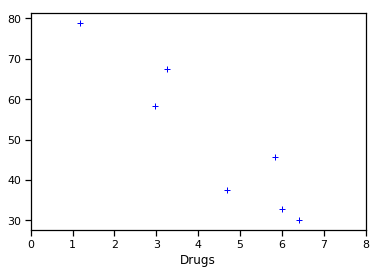

In [6]:
lsd_and_math.plot(x='Drugs', y='Score', style='b+', legend=False, xlim=(0,8));

Let's build a model to characterize the relationship between $X$ and $Y$, recognizing that additional factors other than $X$ (the ones we have measured or are interested in) may influence the response variable $Y$.

In general,

$$M(Y|X) = f(X)$$

for a paramteric regression model,

$$M(Y|X) = f(X, \beta, \epsilon)$$

where $f$ is some function, for example a linear function of the parameters. And if you have more than one dimension of independent variables, you can associate a paramter to each:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_{1i} + \ldots + \beta_k x_{ki} + \epsilon_i$
</div>

Regression is a **weighted sum** of independent predictors

$\epsilon_i$ accounts for the difference between the observed response $y_i$ and its prediction from the model $\hat{y_i} = \beta_0 + \beta_1 x_i + \ldots$. 

This is sometimes referred to as **process uncertainty**.


## 1. Linear sum of squares

We would like to select $\beta_0, \beta_1$ so that the difference between the predictions and the observations is zero, but this is not usually possible. Instead, we choose a reasonable criterion: ***the smallest sum of the squared differences between $\hat{y}$ and $y$***.

<div style="font-size: 120%;">  
$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$  
</div>

Squaring serves two purposes: 

1. To prevent positive and negative values from cancelling each other out
2. To strongly penalize large deviations. 

Whether or not the latter is a desired depends on the goals of the analysis.

In other words, we will select the parameters that minimize the squared error of the model. Let's assume a single indepndent variable $x$:

In [7]:
sum_of_squares = lambda θ, x, y: np.sum((y - θ[0] - θ[1] * x)**2)

Here is a sample calculation, using aribitrary parameter values:

lsd_amd_math

In [8]:
sum_of_squares([0,0.7], lsd_and_math.Drugs, lsd_and_math.Score)

17871.324725000006

However, we have the stated objective of minimizing the sum of squares, so we can pass this function to one of several optimizers in SciPy:

In [9]:
from scipy.optimize import fmin

x, y = lsd_and_math.T.values
b0, b1 = fmin(sum_of_squares, [0,1], args=(x,y))
b0, b1

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179


(89.12390920980424, -9.00946965833095)

Let's plot:

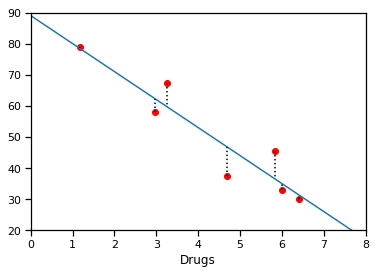

In [10]:
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8), ylim=(20, 90))
ax.plot([0,10], [b0, b0+b1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, b0+b1*xi], 'k:')

## 2. Alternative loss functions

Minimizing the sum of squares is not the only criterion we can use; it is just a very popular, classic one. For example, we can try to minimize the sum of absolute differences:

In [13]:
sum_of_absval = lambda θ, x, y: np.sum(np.abs(y - θ[0] - θ[1] * x)**2)

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 96
         Function evaluations: 186

intercept: 8.9e+01, slope: -9.0


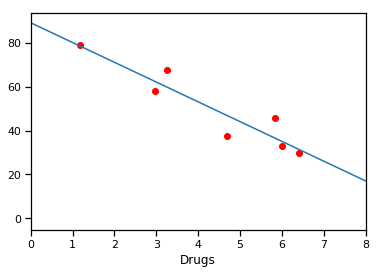

In [14]:
b0, b1 = fmin(sum_of_absval, [0,0], args=(x,y))
print('\nintercept: {0:.2}, slope: {1:.2}'.format(b0,b1))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
ax.plot([0,10], [b0, b0+b1*10])

## 3. Polynomial regession

We are not restricted to a straight-line regression model either. We can represent a curved relationship between our variables by introducing **polynomial** terms. For example, a **cubic** model:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$
</div>

In [21]:
sum_squares_quad = lambda θ, x, y: np.sum((y - (θ[0] + θ[1] * x + θ[2] * x**2)**2))


intercept: -4.7e+52, x: -7.6e+52, x2: -1.1e+53


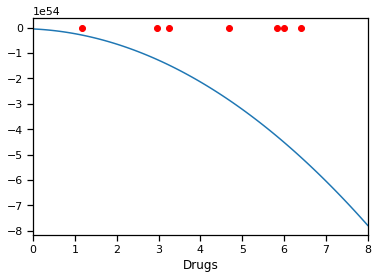

In [22]:
b0,b1,b2 = fmin(sum_squares_quad, [1,1,-1], args=(x,y))
print('\nintercept: {0:.2}, x: {1:.2}, x2: {2:.2}'.format(b0,b1,b2))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
xvals = np.linspace(0, 8, 100)
ax.plot(xvals, b0 + b1*xvals + b2*(xvals**2))

## 4. High-order-Polynomial regession

Are more parameters always better? Not necessarily, from the standpoint of model fit. For example, fitting a **6th order polynomial** to the LSD example certainly results in an **overfit**.

Note `np.c_` translates slice objects to concatenation along the second axis. It's another way of doing array concatenate. See [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html).

Optimization terminated successfully.
         Current function value: 304.786763
         Iterations: 830
         Function evaluations: 1284


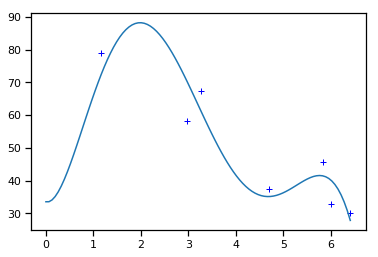

In [24]:
def calc_poly(params, data):
        x = np.c_[[data**i for i in range(len(params))]]
        return np.dot(params, x)

x, y = lsd_and_math.T.values
    
sum_squares_poly = lambda θ, x, y: np.sum((y - calc_poly(θ, x)) ** 2)
betas = fmin(sum_squares_poly, np.zeros(7), args=(x,y), maxiter=1e6)
plt.plot(x, y, 'b+')
xvals = np.linspace(0, max(x), 100)
plt.plot(xvals, calc_poly(betas, xvals))

## 5. Information-theoretic Criteria

How to pick the right model? One approach is to use an information-theoretic criterion to select the most appropriate model. For example **Akaike's Information Criterion (AIC)** balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can calculate AIC as:

$$AIC = n \log(\hat{\sigma}^2) + 2p$$

where $p$ is the number of parameters in the model and $\hat{\sigma}^2 = \text{RSS}/(n-p-1)$, where RSS is [this](https://en.wikipedia.org/wiki/Residual_sum_of_squares).

Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

AIC is a metric of **information distance** between a given model and a notional "true" model. Since we don't know the true model, the AIC value itself is not meaningful in an absolute sense, but is useful as a relative measure of model quality.

To apply AIC to model selection, we choose the model that has the **lowest** AIC value.

In [26]:
n = len(x)

aic = lambda rss, p, n: n * np.log(rss/(n-p-1)) + 2*p

RSS1 = sum_of_squares(fmin(sum_of_squares, [0,1], args=(x,y)), x, y)
RSS2 = sum_squares_quad(fmin(sum_squares_quad, [1,1,-1], args=(x,y)), x, y)

print('\nModel 1: {0}\nModel 2: {1}'.format(aic(RSS1, 2, n), aic(RSS2, 3, n)))

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179

Model 1: 33.05400811127588
Model 2: nan


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Hence, on the basis of "information distance", we would select the 2-parameter (linear) model.

Although a polynomial model characterizes a nonlinear relationship, it is a linear problem in terms of estimation. That is, the regression model $f(y \; |\; x)$ is **linear in the parameters**.

## 6. Bayesian Linear Regression with PyMC3

In practice, we need not fit least squares models by hand because they are implemented generally in packages such as [`scikit-learn`](http://scikit-learn.org/) and [`statsmodels`](https://github.com/statsmodels/statsmodels/). 

But we are not always interested in just obtaining a line of best fit. We also want **estimates of uncertainty** in the line and the parameters used to calculate the line.

Let's turn to a **Bayesian approach** and build a **Bayesian regression model** with PyMC3. In a Bayesian model, instead of **minimizing distance** between data and the model, we pick probabilistic parameters that **maximize the probability** of observing the real data.

### Likelihood

We'll pick a normal distribution as our model, with a mean and a standard deviation as parameters:

$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

Here, $\mu_i$ is the expected value of the *i*th observation (test score), which is generated by the regression model at the corresponding value of $x$ (amount of drug ingested). We calculate this expected value as a function of the regression parameters and the data.

### Priors
The first step in specifying our model is to specify **priors** for our model.

We'll use a **linear model** for μ:

$$μ = \text{intercept} + \text{slope}*x$$
    
and Normal pdfs for `intercept` and `slope`:

$$\text{intercept}, \text{slope} \sim \text{Normal}(0, 100)$$

and also

$$\sigma \sim \text{HalfCauchy}(1)$$

The **half-Cauchy** distribution (half of a [Cauchy](https://en.wikipedia.org/wiki/Cauchy_distribution)) has support over positive continuous values, and relatively large tail probabilities, allowing for the possibility of extreme values. That is another very often used modeling pdf.

In [29]:
from pymc3 import Normal, Model, HalfCauchy

with Model() as this_is_my_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope = Normal('slope', 0, sd=100)
    σ = HalfCauchy('σ', 1)

Let's plot the half Cauchy. [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) is a non-parametric way to estimate the probability density function of a random variable, we'll use Seaborn's KDE method to plot.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


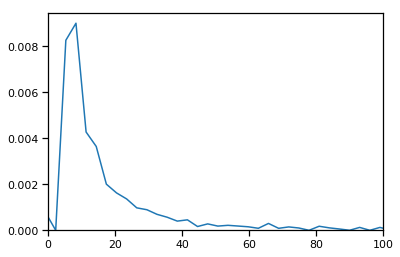

In [30]:
from pymc3 import HalfCauchy

ax = sns.kdeplot(HalfCauchy.dist(1).random(size=10000), gridsize=2000)
ax.set_xlim(0, 100);

Build the model for `μ`, and `score` as a function of `μ` and `σ`:

In [35]:
x,y = lsd_and_math.T.values

with this_is_my_model:
    
    μ = intercept + slope *x
    score = Normal('score', μ, sd=σ, observer=y)

TypeError: __init__() got an unexpected keyword argument 'observer'

All right, all right, all right! Now your regression model is fully specified and you are ready to track your **posteriors**.

</br >
<center>
<img src="https://media1.tenor.com/images/c4b036354e1a6e6fedd3809a0c945003/tenor.gif?itemid=5146096" width="400" />
All right, all right, all right
</center>
We can now use the fitting method of our choice to estimate a posterior distribution. Let's use a **Markov chain Monte Carlo** algorithm, called **NUTS** (the No U-Turn Sampler).

In [32]:
from pymc3 import sample

with this_is_my_model:

    lsd_sample = sample(1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, slope, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4071.58draws/s]


Let's plot posteriors:

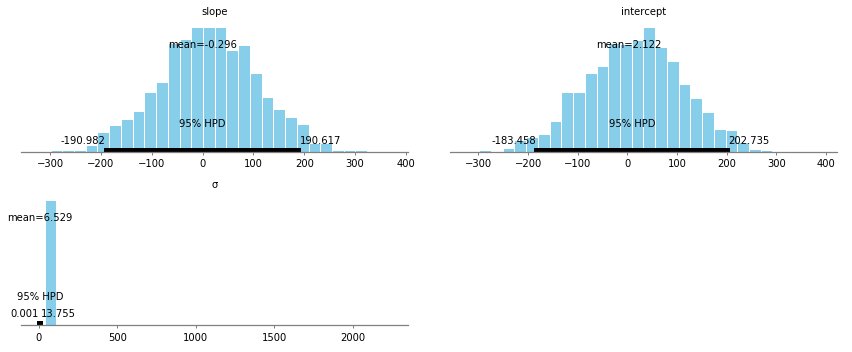

In [33]:
from pymc3 import plot_posterior

plot_posterior(lsd_sample[500:], varnames=['slope', 'intercept', 'σ']);

# Checking model fit

Let's evaluate model fit by comparing model predictions with the observations used to fit a model. The fitted model can be used to **simulate data**, and the distribution of the simulated data should resemble the distribution of the actual data.

Ssimulating data from the model is a natural component of the Bayesian modelling framework. Recall, from our introduction to Bayesian inference, the **posterior predictive distribution**:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be expected, taking into account the posterior uncertainty in the model parameters. 

Sampling from the posterior predictive distribution is straighforward in PyMC; the `sample_ppc` function draws posterior predictive checks from all of the data likelihoods. 

In [36]:
from pymc3 import sample_ppc

with this_is_my_model:
    
    lsd_ppc = sample_ppc(lsd_sample, 1000)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
100%|██████████| 1000/1000 [00:00<00:00, 54740.92it/s]


This yields 1000 samples corresponding to each of the seven data points in our observation vector.

In [38]:
lsd_ppc['score'].shape

KeyError: 'score'

We can then compare these simulated data to the data we used to fit the model. 

The model should prove that it could have been used to generate the data that we observed.

KeyError: 'score'

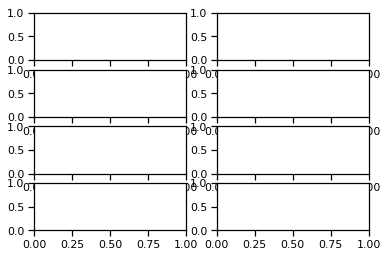

In [39]:
fig, axes = plt.subplots(4, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:-1], y, lsd_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

axes_flat[-1].axis('off')
plt.tight_layout()

Not too bad.

</br >
<center>
<img src="ipynb.images/scoobs.png" width=200 />
</center>

What are we saying about the model? A good Bayesian model is one whereby the test score is a normal distribution, where the mean of that distribution is a linear function of the amount of drug ingested. If we use the model, we can now make guesses for different drug data points, and obtain predicted test scores as well as errors we make in the predictions.